In [192]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
import pickle
import scipy.optimize as opt
from uncertainties import ufloat
from uncertainties.umath import *
import datetime
pd.options.display.max_seq_items = 2000

In [193]:
openfile=open( r"C:\Users\Joseph\Documents\Beamly\TakeHomeTask\beamly_case_study_noNaNs.pickle", "rb")
df=pickle.load(openfile)
openfile.close()

In [194]:
device_date=df.groupby(by=['device_name', 'date']).sum()

In [195]:

df_e=df
df_e['weekday']=df['date'].apply(lambda x:pd.to_datetime(x).weekday())
device_weekday=df_e.groupby(by=['productBand', 'weekday']).sum()['total_products'].unstack(0)

In [196]:
modelling_df=df.groupby(by=['productBand', 'date']).sum()['total_products'].unstack(0)

In [197]:

def salescount_poisson(B12,B23):
    var1,var2=0.5646645900308181,0.3583200942112118
    return (var1*B12+var2*B23)/2.


### There are two ways you could deal with the data below, by maybe taking ou the wekly trends, but I'm not sure this is the best idea.

def scale_total_products_modelling(row,dwd,col):
    scaler=dwd[col].apply(lambda x:x/dwd[col].mean())
    weekday_temp=pd.to_datetime(row.name).weekday()
    #print(scaler,weekday_temp,scaler[weekday_temp])
    return row[col]/scaler[weekday_temp]
forecast_august=modelling_df
for column in modelling_df.columns:
    forecast_august[column]=modelling_df.apply(lambda row:scale_total_products_modelling(row,device_weekday,column),axis=1)
forecast_august['between30and40']=forecast_august.apply(lambda x:salescount_poisson(x['between10and20'],x['between20and30']),axis=1)
forecast_august.drop(forecast_august.index[len(forecast_august)-1],inplace=True)

In [198]:
forecast_august=modelling_df
forecast_august['between30and40']=forecast_august.apply(lambda x:salescount_poisson(x['between10and20'],x['between20and30']),axis=1)
forecast_august.drop(forecast_august.index[len(forecast_august)-1],inplace=True)

In [199]:
def movingaverage(interval, window_size):
    """ 
    A function to calculate a moving average, useful for looking at data trends and for dampening noise in a less artificial way.
    """
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [200]:
forecast_august.head()

productBand,between10and20,between20and30,between40and50,lessThan10,moreThan50,price_missing,between30and40
date,,,,,,,
2018-07-01,219.0,230.0,41.0,160.0,18.0,42.0,103.037583
2018-07-02,247.0,269.0,32.0,195.0,32.0,60.0,117.930130
2018-07-03,246.0,286.0,22.0,121.0,26.0,55.0,120.693518
2018-07-04,206.0,250.0,28.0,182.0,17.0,52.0,102.950465
2018-07-05,242.0,271.0,47.0,179.0,27.0,51.0,116.876788


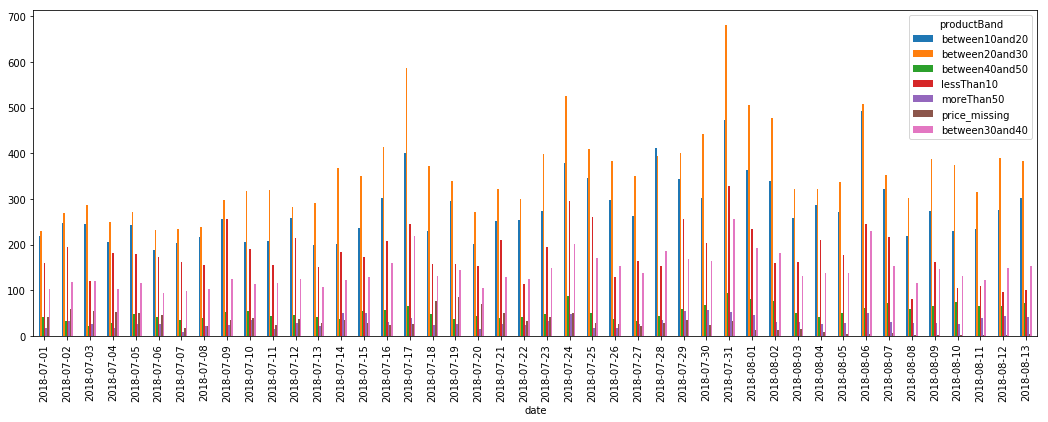

In [201]:
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august.plot(kind='bar', ax=ax)

## Forecast New Line
Estimate the sales of the new line from this forecasting.

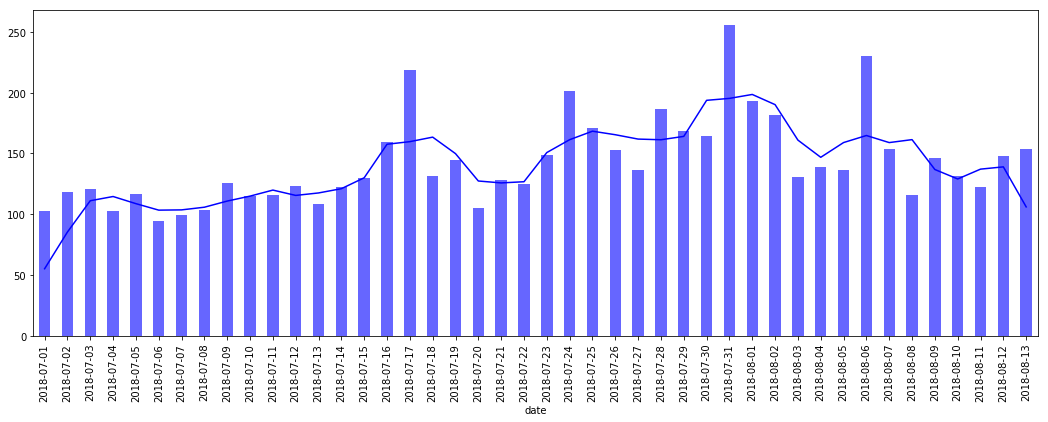

In [202]:
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august['between30and40'].plot(kind='bar', ax=ax,color='blue',alpha=0.6,label='between30and40')
move_av_30to40=movingaverage(forecast_august['between30and40'].values,4)
ax.plot(move_av_30to40,color='blue')

In [235]:
def monthly_trend_forecaster(t,x):
    return x[0]*np.sin(x[1]*t+x[2]) + x[3]

In [228]:
forecast_august.reset_index(inplace=True)

In [241]:
#between20and30 first
y=movingaverage(forecast_august['between30and40'].values,6)
x1=forecast_august.index
guess_mean = np.mean(y)
guess_phase = 0
guess_freq = 0.3
guess_amp = 1
guess= [guess_amp, guess_freq, guess_phase, guess_mean]
errfunc = lambda o, x1, y: monthly_trend_forecaster(x1,o) - y # Distance to the target function, through linear combination.
fullout = opt.leastsq(errfunc, guess[:], args=(x1, y),full_output=1)
o1,cov_o1,infodict,mesg,ier=fullout
perr = np.sqrt(np.diag(cov_o1))
print(o1,perr)
print(np.mean(y))

[-4.50073660e+01  9.98492458e-02 -1.06117431e+01  1.24526785e+02] [0.50206944 0.00107696 0.02990408 0.5979099 ]
138.13315149591853


In [270]:
#associate o1 with errors
# ltt=Long Term Trend
ltt_ampl = ufloat(o1[0],perr[0])
ltt_freq = ufloat(o1[1],perr[1])
ltt_phas = ufloat(o1[2],perr[2])
ltt_mean = ufloat(o1[3],perr[3])
ltt_paras= [ltt_ampl, ltt_freq, ltt_phas, ltt_mean]

In [242]:
error_comb_o1=np.sqrt((perr[0]/o1[0])**2+(perr[1]/o1[1])**2+(perr[2]/o1[2])**2)+(perr[3]/o1[3])
print(error_comb_o1)

0.020572164560163496


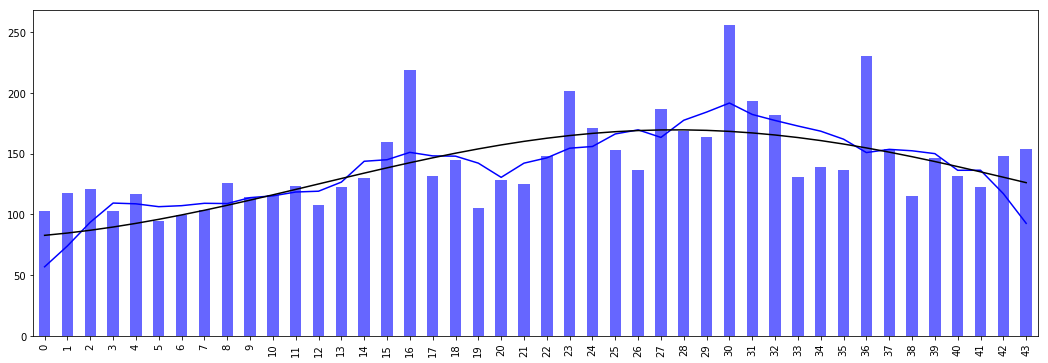

In [243]:
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august['between30and40'].plot(kind='bar', ax=ax,color='blue',alpha=0.6,label='between30and40')
ax.plot(y,color='blue')
ax.plot(x1,monthly_trend_forecaster(x1,o1),color='k')

[ -6.81953478   1.16019153   0.93586808 140.82014914] [[ 4.55398543e-02 -1.97501828e-06  1.57820095e-04 -4.88136096e-04]
 [-1.97501828e-06  6.06579617e-06 -1.32652561e-04  2.32103577e-05]
 [ 1.57820095e-04 -1.32652561e-04  3.87761126e-03 -4.31521353e-04]
 [-4.88136096e-04  2.32103577e-05 -4.31521353e-04  2.28272734e-02]]
140.74682342162677


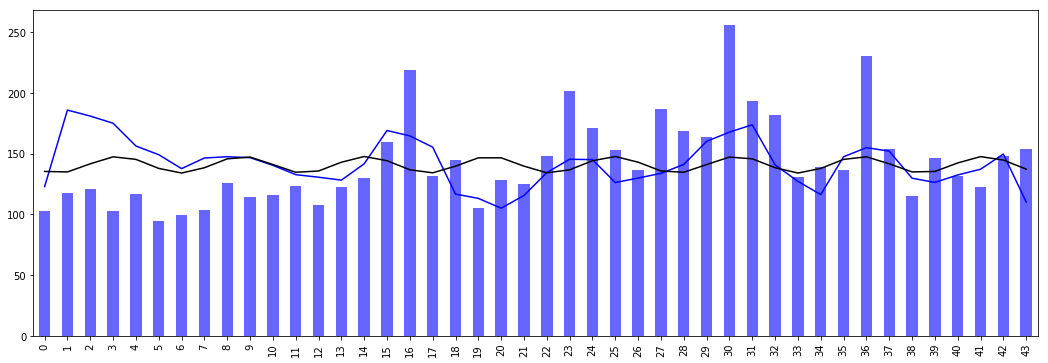

In [256]:
#between20and30 first
move_av_30to40=movingaverage(forecast_august['between30and40'].values,3)
y=move_av_30to40
x1=forecast_august.index
guess_mean = np.mean(y)
guess_std = 3*np.std(y)/(2**0.5)/(2**0.5)
guess_phase = 1
guess_freq =1
guess_amp = 1
guess= [guess_amp, guess_freq, guess_phase, guess_mean]
errfunc = lambda o, x1, y: monthly_trend_forecaster(x1,o) - y # Distance to the target function, through linear combination.
fullout = opt.leastsq(errfunc, guess[:], args=(x1, y),full_output=1)
o2,cov_o2,infodict,mesg,ier=fullout
perr2 = np.sqrt(np.diag(cov_o2))
print(o2,cov_o2)
print(np.mean(y))
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august['between30and40'].plot(kind='bar', ax=ax,color='blue',alpha=0.6,label='between30and40')
ax.plot(move_av_30to40/(monthly_trend_forecaster(x1,o1)/np.mean(monthly_trend_forecaster(x1,o1))),color='blue')
ax.plot(x1,monthly_trend_forecaster(x1,o2),color='k')

In [271]:
#associate o1 with errors
# ltt=Short Term Trend
stt_ampl = ufloat(o2[0],perr2[0])
stt_freq = ufloat(o2[1],perr2[1])
stt_phas = ufloat(o2[2],perr2[2])
stt_mean = ufloat(o2[3],perr2[3])
stt_paras= [stt_ampl, stt_freq, stt_phas, stt_mean]

In [257]:
error_comb_o2=np.sqrt((perr2[0]/o2[0])**2+(perr2[1]/o2[1])**2+(perr2[2]/o2[2])**2)+(perr2[3]/o2[3])
print(error_comb_o2)

0.0746323408948566


In [258]:
error_percent_tot=np.sqrt(error_comb_o1**2+error_comb_o2**2)

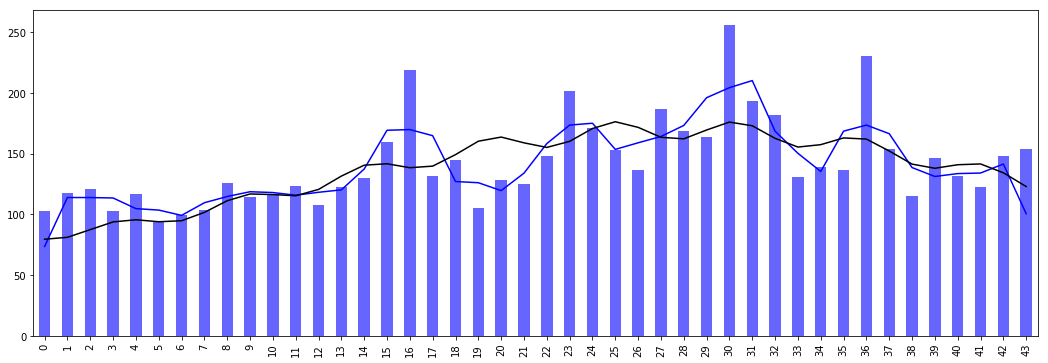

In [278]:
#def comb_func(x1,o1,o2):
#    return (monthly_trend_forecaster(x1,o1)+monthly_trend_forecaster(x1,o2))/2.#This dampens the signal a little, better to use the lower function
def comb_func(x1,o1,o2):
    return (monthly_trend_forecaster(x1,o1)*monthly_trend_forecaster(x1,o2))/np.mean(monthly_trend_forecaster(x1,o2))
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august['between30and40'].plot(kind='bar', ax=ax,color='blue',alpha=0.6,label='between30and40')
ax.plot(move_av_30to40,color='blue')
ax.plot(x1,comb_func(x1,o1,o2),color='k')#this worked before, but not good errors

## Forecast Sales for last two weeks
In coding terms this is from days 44->60

In [260]:
newdates=np.arange(44,61,1)
b34sales=comb_func(newdates,o1,o2)

In [261]:
df_b34=pd.DataFrame(b34sales,index=newdates)
df_b34

,0
44,116.042171
45,115.931654
46,117.287582
47,113.380798
48,104.219803
49,96.080273
50,93.822384
51,95.433041
52,94.894921
53,89.439067


assign new dates

In [262]:
def assigndates(row):
    r44=pd.to_datetime('2018-08-14')
    year = r44.year
    month = r44.month
    day = r44.day+(row.name-44)
    return datetime.date(year, month, day)
df_b34['date']=df_b34.apply(lambda row:assigndates(row),axis=1)
df_b34

,0,date
44,116.042171,2018-08-14
45,115.931654,2018-08-15
46,117.287582,2018-08-16
47,113.380798,2018-08-17
48,104.219803,2018-08-18
49,96.080273,2018-08-19
50,93.822384,2018-08-20
51,95.433041,2018-08-21
52,94.894921,2018-08-22
53,89.439067,2018-08-23


In [263]:
df_b34.reset_index(inplace=True)
df_b34.set_index('date',inplace=True)
df_b34.head()

,index,0
date,,
2018-08-14,44,116.042171
2018-08-15,45,115.931654
2018-08-16,46,117.287582
2018-08-17,47,113.380798
2018-08-18,48,104.219803


In [264]:
df_b34.drop(['index'],axis=1,inplace=True)

In [265]:
df_b34.rename(columns={0: "forecast_B30to40"},inplace=True)

In [294]:
def monthly_trend_forecaster(t,x):
    x1in=x[1]*t
    return x[0]*sin(x1in+x[2]) + x[3]
def error_forecaster(t,para1,para2):
    print(sin(para1[1]*t+para1[2]),t)
    return sqrt(monthly_trend_forecaster(t,para1)**2+monthly_trend_forecaster(t,para2)**2).s
df_b34['forecast_error']=df_b34["forecast_B30to40"].apply(lambda x:error_forecaster(x,ltt_paras,stt_paras))
df_b34.head()

0.83+/-0.07 116.04217106358387
0.82+/-0.07 115.93165403273852
0.89+/-0.06 117.28758162810058
0.65+/-0.10 113.38079832214427
-0.20+/-0.11 104.21980264134147
-0.85+/-0.06 96.08027264500068
-0.947+/-0.034 93.82238406578031
-0.88+/-0.05 95.43304098747286
-0.91+/-0.04 94.89492125512339
-0.994+/-0.011 89.43906721865969
-0.70+/-0.07 82.54814451816742
-0.46+/-0.08 79.58870595619437
-0.62+/-0.07 81.54983607947655
-0.80+/-0.06 84.13597962538255
-0.73+/-0.06 82.96214485315294
-0.37+/-0.08 78.6588311705524
-0.12+/-0.09 76.05224267376305


,forecast_B30to40,forecast_error
date,,
2018-08-14,116.042171,2.299983
2018-08-15,115.931654,2.381217
2018-08-16,117.287582,1.514088
2018-08-17,113.380798,2.840095
2018-08-18,104.219803,3.746308


This is quite a novel way of calculating errors, but I'm not completely convinced. This package gives +- as the same value, although this is technically impossible, so obviously a bit unreliable. Hilariously I know that academics use this package blindly.

In [296]:
df_b34['forecast_error']=df_b34.apply(lambda x:x*error_percent_tot)
df_b34.head()

,forecast_B30to40,forecast_error
date,,
2018-08-14,116.042171,8.983493
2018-08-15,115.931654,8.974937
2018-08-16,117.287582,9.079908
2018-08-17,113.380798,8.777461
2018-08-18,104.219803,8.068255


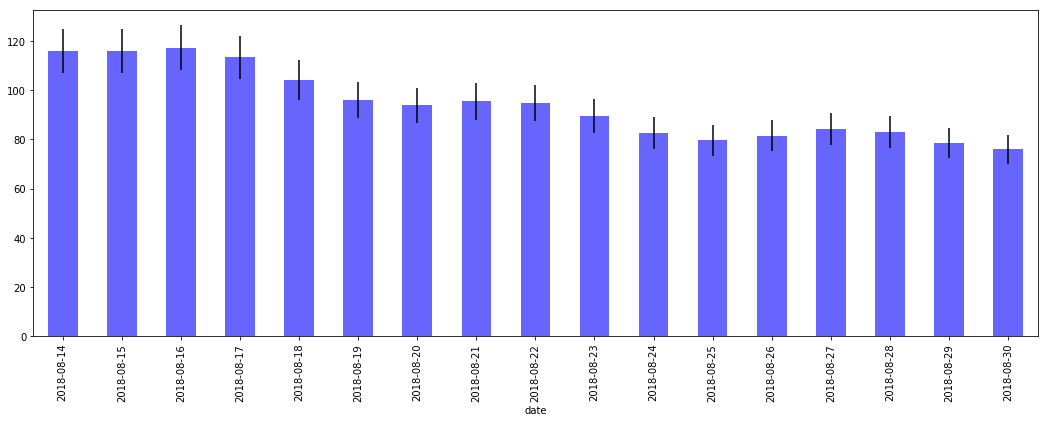

In [297]:
f, ax = plt.subplots(1,figsize=(18,6))
df_b34['forecast_B30to40'].plot(kind='bar',yerr=df_b34['forecast_error'], ax=ax,color='blue',alpha=0.6,label='Forecast_30to40')

Ok the errors are very small, my model is convinced it is very good. The best way to work out the error on this would be to use a grid search method, but that would take a lot of time to build right now, so this will have to do.